In [34]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

### Prepare data for analys

In [4]:
data = pd.read_csv(filepath_or_buffer='/home/kharlamov/Документы/Project/output/ListProteins.csv')
data = data[data.columns[1:]]

/home/kharlamov/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data['sum'] = data.loc[:,"freq_A":"freq_X"].sum(axis=1)
data.loc[:,"freq_A":"freq_X"] = data.loc[:,"freq_A":"freq_X"].div(data["sum"], axis=0)
data = data[data.columns[:-1]]

In [6]:
data.to_csv(path_or_buf='/home/kharlamov/Документы/Project/data/ListProteinsFreq.csv')

In [7]:
data.rename(columns={name : name.split('_')[1] for name in list(data.columns[4:])}, inplace = True)

In [8]:
data_tmp = data[data.columns[3:]]
data_tmp[data_tmp.columns[0]] = map(lambda x: 0 if x == 'human' else 1, data_tmp[data_tmp.columns[0]])
data_tmp = data_tmp[data_tmp.columns[:-1]]

/home/kharlamov/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
labels_name = map(lambda x: 'human' if x == 1 else 'bacteria or virus', data_tmp['type'])
labels_numeric = data_tmp['type']
data_tmp = data_tmp[['type', 'A', 'N', 'C', 'E', 'H', 'L', 'M', 'P', 'T', 'Y', 'R', 'D', 'Q', 'G', 'I', 'K', 'F', 'S', 'W', 'V']]

#### Запуск линейной регрессии и все такое

In [10]:
data_train, data_test = train_test_split(data_tmp, test_size=0.2)

In [11]:
data_train_x, data_train_y = data_train[data_train.columns[1:]], data_train[data_train.columns[0]]
data_test_x, data_test_y = data_test[data_train.columns[1:]], data_test[data_train.columns[0]]

#### RandomForest

In [19]:
clf = RandomForestClassifier(n_estimators = 100, random_state=14883371)

In [20]:
clf.fit(data_train_x, data_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=14883371, verbose=0,
            warm_start=False)

In [21]:
print('Accuracy on train = ' + str(clf.score(data_train_x, data_train_y)))
print('Accuracyc on test = ' + str(clf.score(data_test_x, data_test_y)))

Accuracy on train = 1.0
Accuracyc on test = 0.9011731581417175


In [16]:
clf.feature_importances_ # Видно, что в среднем все аминокислоты дают равный вклад

array([1.06005588e-01, 6.65275553e-06, 1.03865202e-01, 4.32493511e-02,
       3.70386328e-02, 2.75628408e-02, 3.00065637e-02, 2.83710533e-02,
       1.15402507e-01, 0.00000000e+00, 5.26282085e-02, 2.63091107e-02,
       2.58992507e-02, 4.07543529e-02, 0.00000000e+00, 7.70046389e-02,
       3.41080754e-02, 3.41251647e-02, 9.00059100e-02, 2.96640104e-02,
       1.54535873e-05, 4.15628718e-02, 2.51676647e-02, 3.12468956e-02,
       0.00000000e+00])

In [17]:
y_pred = clf.predict(data_test_x)
print('F1 Score = ' + str(f1_score(y_pred, data_test_y)))

F1 Score = 0.8189803651395109


In [18]:
print('ROC AUC = ' + str(roc_auc_score(y_pred, data_test_y)))

ROC AUC = 0.9047084167340971


In [19]:
score_cross_val = cross_val_score(clf, data_tmp[data_tmp.columns[1:]],data_tmp['type'], cv = 8, n_jobs=-1)

array([0.83219461, 0.89638862, 0.88565208, 0.89353555, 0.90081838,
       0.91808079, 0.92003304, 0.89908395])

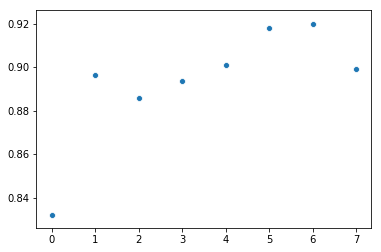

In [20]:
sns.scatterplot(x = [i for i in range(len(score_cross_val))], y = score_cross_val)
score_cross_val #Видно, что в среднем на кросс валидации результат около 90%

### Logistic Regression

In [35]:
clf_2 = LogisticRegression(max_iter=10**6, C=10000) # Регулиризация была настроена по gridsearch'у

In [37]:
cross_val_score(clf_2, data_tmp[data_tmp.columns[1:]],data_tmp['type'], cv = 8, n_jobs=-1).mean() 
# Видно, что с RF разница 8%

0.8275634419893712

In [12]:
#Попробуем улучшить результат путем PolynominalFeauture.
data_y = data_tmp['type']
data_x = data_tmp[data_tmp.columns[1:]]
Poly = PolynomialFeatures(degree=2)

In [13]:
data_poly_transform = pd.DataFrame(Poly.fit_transform(data_x, data_y))
data_poly_transform = data_poly_transform[data_poly_transform.columns[1:]]

In [14]:
data_poly_transform.head()

,1,2,3,4,5,6,7,8,9,10,...,341,342,343,344,345,346,347,348,349,350
0,0.055072,0.0,0.075362,0.060870,0.046377,0.034783,0.084058,0.031884,0.040580,0.0,...,0.004839,0.001210,0.002621,0.0,0.000302,0.000655,0.0,0.001420,0.0,0.0
1,0.092025,0.0,0.018405,0.036810,0.055215,0.036810,0.116564,0.024540,0.018405,0.0,...,0.007377,0.002108,0.002635,0.0,0.000602,0.000753,0.0,0.000941,0.0,0.0
2,0.046875,0.0,0.000000,0.015625,0.046875,0.093750,0.000000,0.015625,0.015625,0.0,...,0.024414,0.000000,0.004883,0.0,0.000000,0.000000,0.0,0.000977,0.0,0.0
3,0.058559,0.0,0.018018,0.018018,0.031532,0.040541,0.072072,0.022523,0.067568,0.0,...,0.006574,0.002191,0.002191,0.0,0.000730,0.000730,0.0,0.000730,0.0,0.0
4,0.043636,0.0,0.018182,0.029091,0.025455,0.032727,0.043636,0.069091,0.061818,0.0,...,0.004774,0.001507,0.003517,0.0,0.000476,0.001111,0.0,0.002592,0.0,0.0


In [16]:
clf_3 = LogisticRegression(max_iter=10**6, C=10000)

In [17]:
cross_val_score(clf_3, data_poly_transform, data_y, cv = 3) # Видно, что стало лучше, но до RF еще далеко

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.84185038, 0.83897398, 0.89052821])

### Others

In [40]:
pca = PCA(n_components=3)
data_tmp_pca = pd.DataFrame(pca.fit_transform(data_poly_transform))
data_tmp_pca.tail()

,0,1,2
106544,0.040460,-0.004320,0.061092
106545,0.081714,0.004064,-0.013576
106546,0.019030,0.001104,0.058905
106547,0.013980,-0.018033,0.056140
106548,-0.039115,-0.014884,0.023004


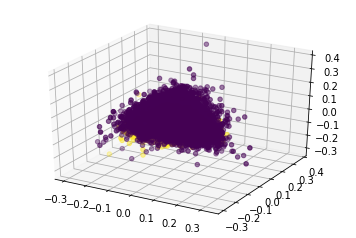

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_tmp_pca[0], data_tmp_pca[1], data_tmp_pca[2], c = labels)

In [49]:
pca = PCA(n_components=3)
data_tmp_1, data_tmp_2 = train_test_split(data_tmp[data_tmp.columns[1:]], test_size = 0.99)
data_tmp_pca_2 = pd.DataFrame(pca.fit_transform(data_tmp[data_tmp_1.columns[1:]]))
data_tmp_pca_2.tail()

,0,1,2
106544,0.025232,0.013911,0.066532
106545,0.075349,-0.025712,-0.094151
106546,-0.001868,0.017161,0.025876
106547,-0.006454,0.038494,0.000726
106548,-0.036305,0.027254,0.001370


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_tmp_pca_2[0], data_tmp_pca_2[1], data_tmp_pca_2[2], c = labels)
for ii in range(0,360,30):
        ax.view_init(elev=10., azim=ii)
        plt.savefig("movie%d.png" % ii)

MemoryError: 

Error in callback <function post_execute at 0x7f19d369e0c8> (for post_execute):


MemoryError: 

# Настраиваемые кривые валидации для RFC

In [128]:
X, y = data_tmp[data_tmp.columns[1:]], data_tmp['type']

In [129]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Инициализируем валидацию

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]
# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Text(0.5,0,'N_estimators')

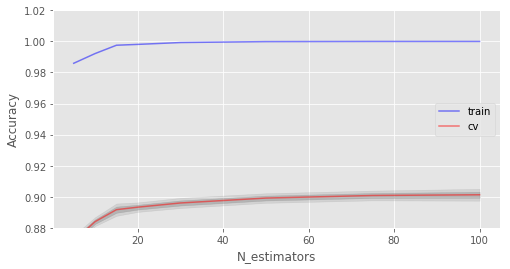

In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

In [20]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=60, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 89.97% with 24 max_depth


Text(0.5,0,'Max_depth')

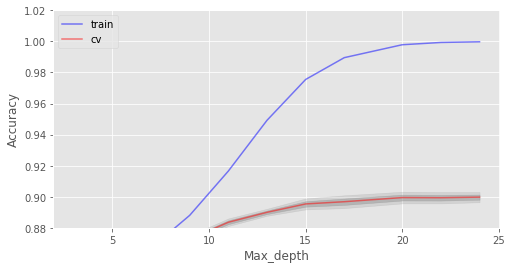

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")

In [23]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=60, max_depth=20, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 89.95% with 1 min_samples_leaf


Text(0.5,0,'Min_samples_leaf')

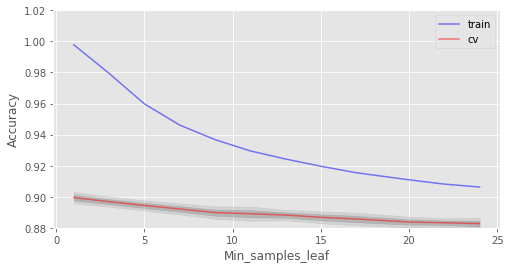

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf")

In [80]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [1,2,3,4,5,6,7,8]

# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=60, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 89.99% with 5 max_features


Text(0.5,0,'Max_features')

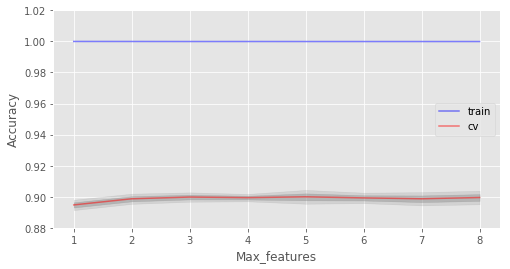

In [81]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features")

In [130]:
rfc = RandomForestClassifier(n_estimators=60, max_features=5, random_state=42, n_jobs=-1, 
                                 oob_score=True)
rfc.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

# Осмотр данных

Text(0.5,0,'PCA_3')

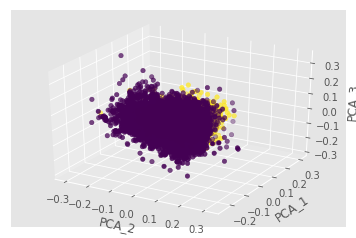

In [45]:
pca = PCA(n_components=3)
data_tmp_1, data_tmp_2 = train_test_split(data_tmp[data_tmp.columns[1:]], test_size = 0.99)
data_tmp_pca_2 = pd.DataFrame(pca.fit_transform(data_tmp[data_tmp_1.columns[1:]]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_tmp_pca_2[0], data_tmp_pca_2[1], data_tmp_pca_2[2], c = labels)
ax.set_ylabel("PCA_1")
ax.set_xlabel("PCA_2")
ax.set_zlabel('PCA_3')

Text(0.5,0,'PCA_2')

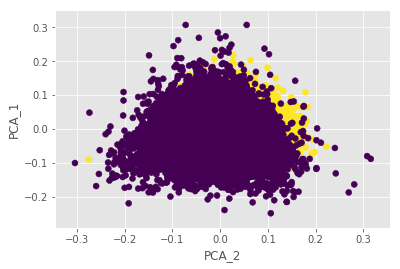

In [44]:
pca = PCA(n_components=2)
data_tmp_1, data_tmp_2 = train_test_split(data_tmp[data_tmp.columns[1:]], test_size = 0.99)
data_tmp_pca_2 = pd.DataFrame(pca.fit_transform(data_tmp[data_tmp_1.columns[1:]]))
fig, ax = plt.subplots()
ax.scatter(data_tmp_pca_2[0], data_tmp_pca_2[1], c = labels)
ax.set_ylabel("PCA_1")
ax.set_xlabel("PCA_2")

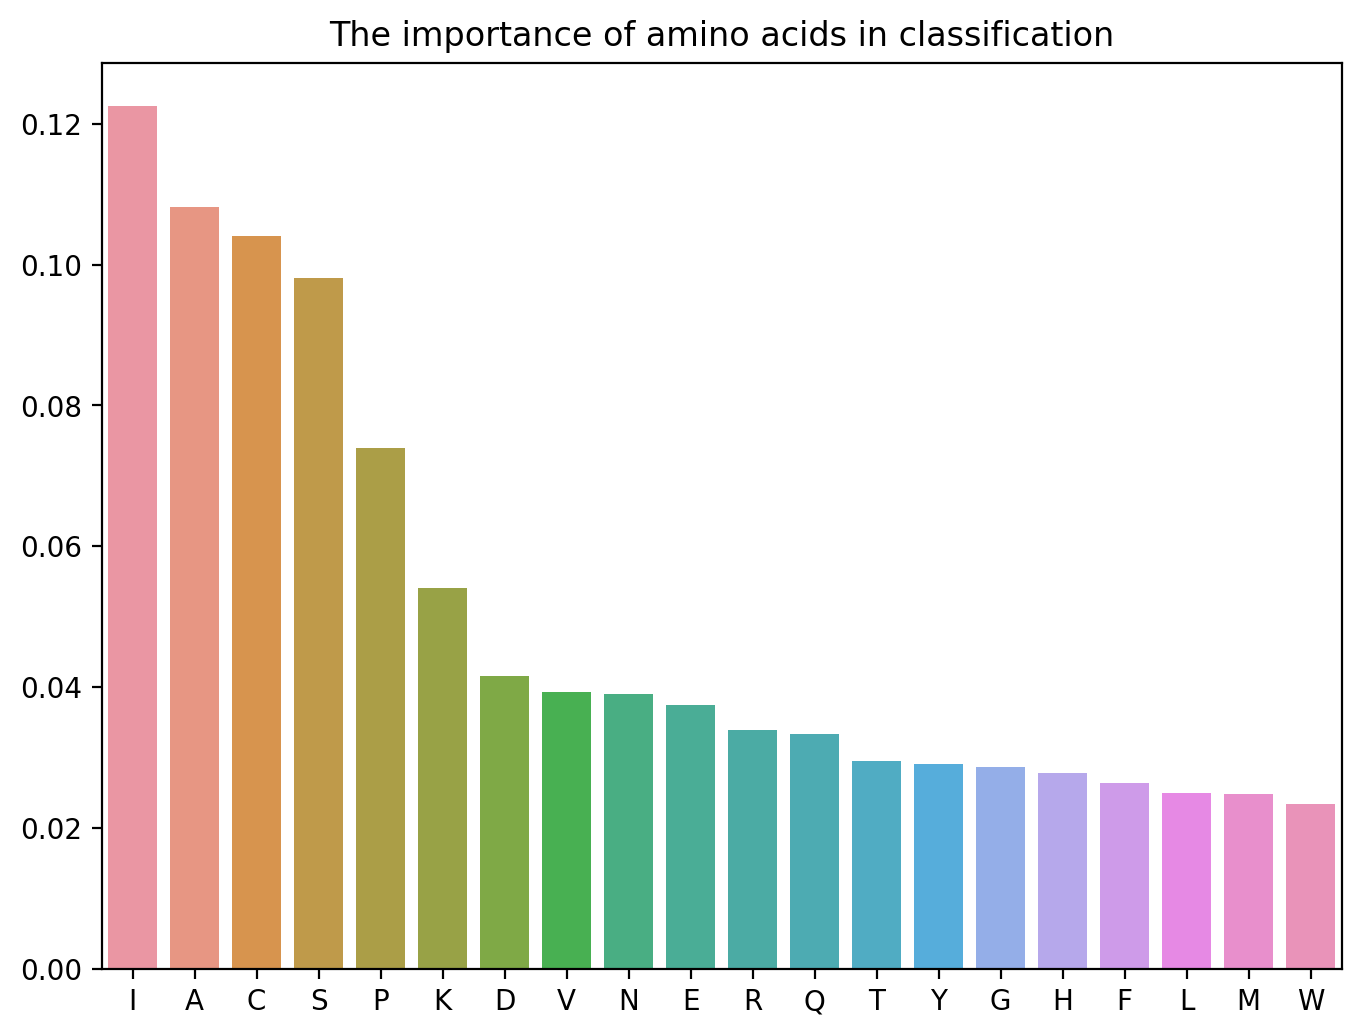

In [131]:
aminoacid = list('ANCEHLMPTYRDQGIKFSWV')
aminoacid_freq = rfc.feature_importances_
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
B = zip(aminoacid, aminoacid_freq)
B.sort(key = lambda x: x[1], reverse=True)
aminoacid = map(lambda x: x[0], B)
aminoacid_freq = map(lambda x: x[1], B)

plt.title('The importance of amino acids in classification')
sns.barplot(aminoacid, aminoacid_freq)

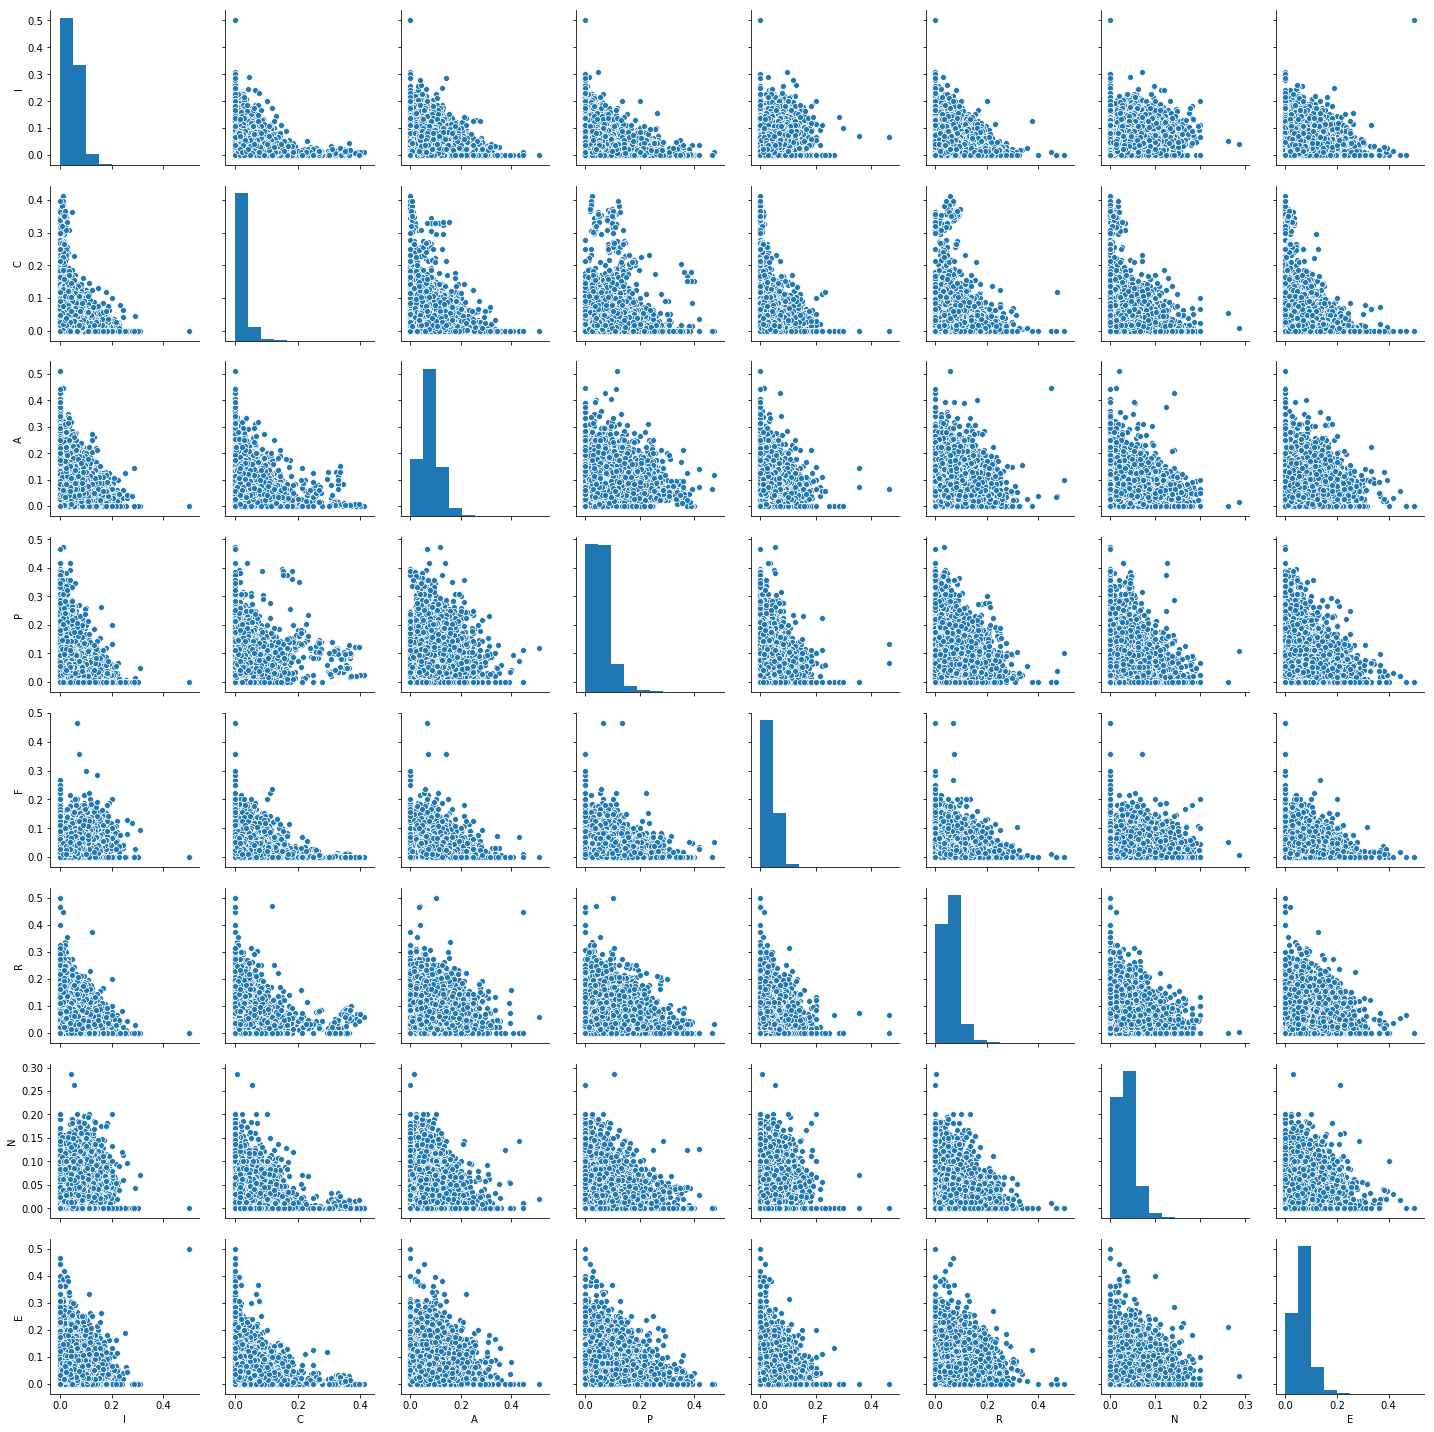

In [154]:
sns.pairplot(data_tmp[['I', 'C', 'A', 'P', 'F', 'R', 'N', 'E']])

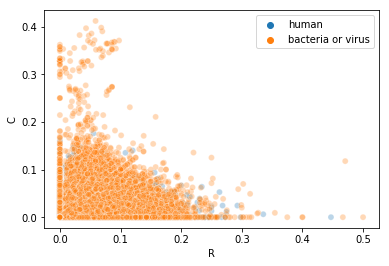

In [162]:
sns.scatterplot(data_tmp['R'], data_tmp['C'], hue = labels, alpha=0.3) 
#Интересное наблюдение, что высокое содержание Цистеин означает не человеческий белок.

## Datasets with equal classes

In [14]:
data_human = data_tmp[data_tmp['type'] == 0]
data_bactvirus = data_tmp[data_tmp['type'] == 1]
df_majority_downsampled = sklearn.utils.shuffle(data_human, 
                                 replace=False,     # sample without replacement
                                 n_samples=len(data_bactvirus),      # to match minority class
                                 random_state=42)  # reproducible results
df_balance = pd.concat([df_majority_downsampled, data_bactvirus])
df_balance.tail()

,type,A,N,C,E,H,L,M,P,T,...,R,D,Q,G,I,K,F,S,W,V
32195,1,0.060241,0.084337,0.012048,0.060241,0.000000,0.096386,0.048193,0.012048,0.036145,...,0.012048,0.048193,0.048193,0.084337,0.072289,0.120482,0.024096,0.048193,0.000000,0.120482
32196,1,0.051661,0.110701,0.007380,0.070111,0.018450,0.110701,0.007380,0.018450,0.025830,...,0.007380,0.051661,0.025830,0.025830,0.066421,0.121771,0.092251,0.092251,0.003690,0.033210
32197,1,0.071429,0.020408,0.000000,0.102041,0.000000,0.081633,0.020408,0.000000,0.081633,...,0.010204,0.020408,0.051020,0.010204,0.051020,0.153061,0.102041,0.061224,0.010204,0.102041
32198,1,0.074913,0.081882,0.001742,0.048780,0.006969,0.069686,0.008711,0.045296,0.078397,...,0.034843,0.064460,0.052265,0.055749,0.047038,0.076655,0.062718,0.067944,0.013937,0.066202
32199,1,0.025937,0.060519,0.000000,0.028818,0.005764,0.118156,0.017291,0.028818,0.025937,...,0.023055,0.028818,0.014409,0.023055,0.097983,0.086455,0.161383,0.080692,0.028818,0.043228


## PCA explained variance, 2d PCA, analyse PCA
### 1. 2d PCA

In [34]:
pca = PCA(n_components=2)
data_pca = df_balance
labels = data_pca['type']
labels_name = map(lambda x: 'human protein' if x == 0 else 'bacterium or virus protein', labels)
data_pca = pd.DataFrame(pca.fit_transform(data_pca[data_pca.columns[1:]]))
data_pca.columns = 'PCA_1', 'PCA_2'

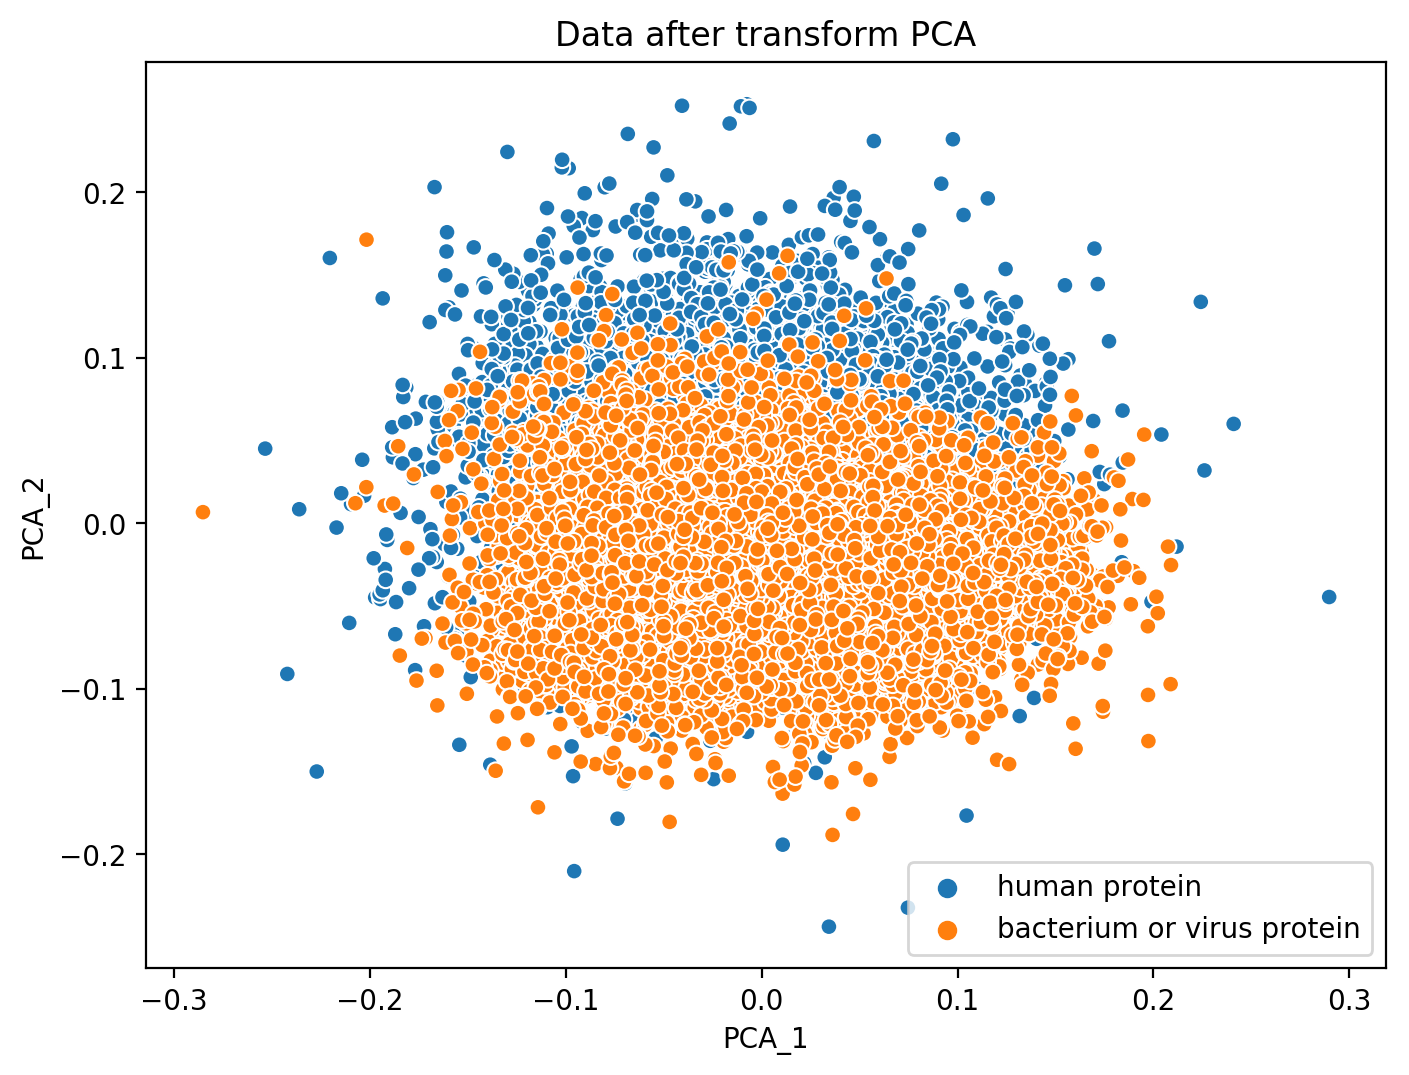

In [42]:
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
ax.set(xlabel="PCA_1", ylabel="PCA_2", title = 'Data after transform PCA')
sns.scatterplot(data_pca['PCA_1'], data_pca['PCA_2'], hue = labels_name, ax = ax)

## 2. PCA explained variance

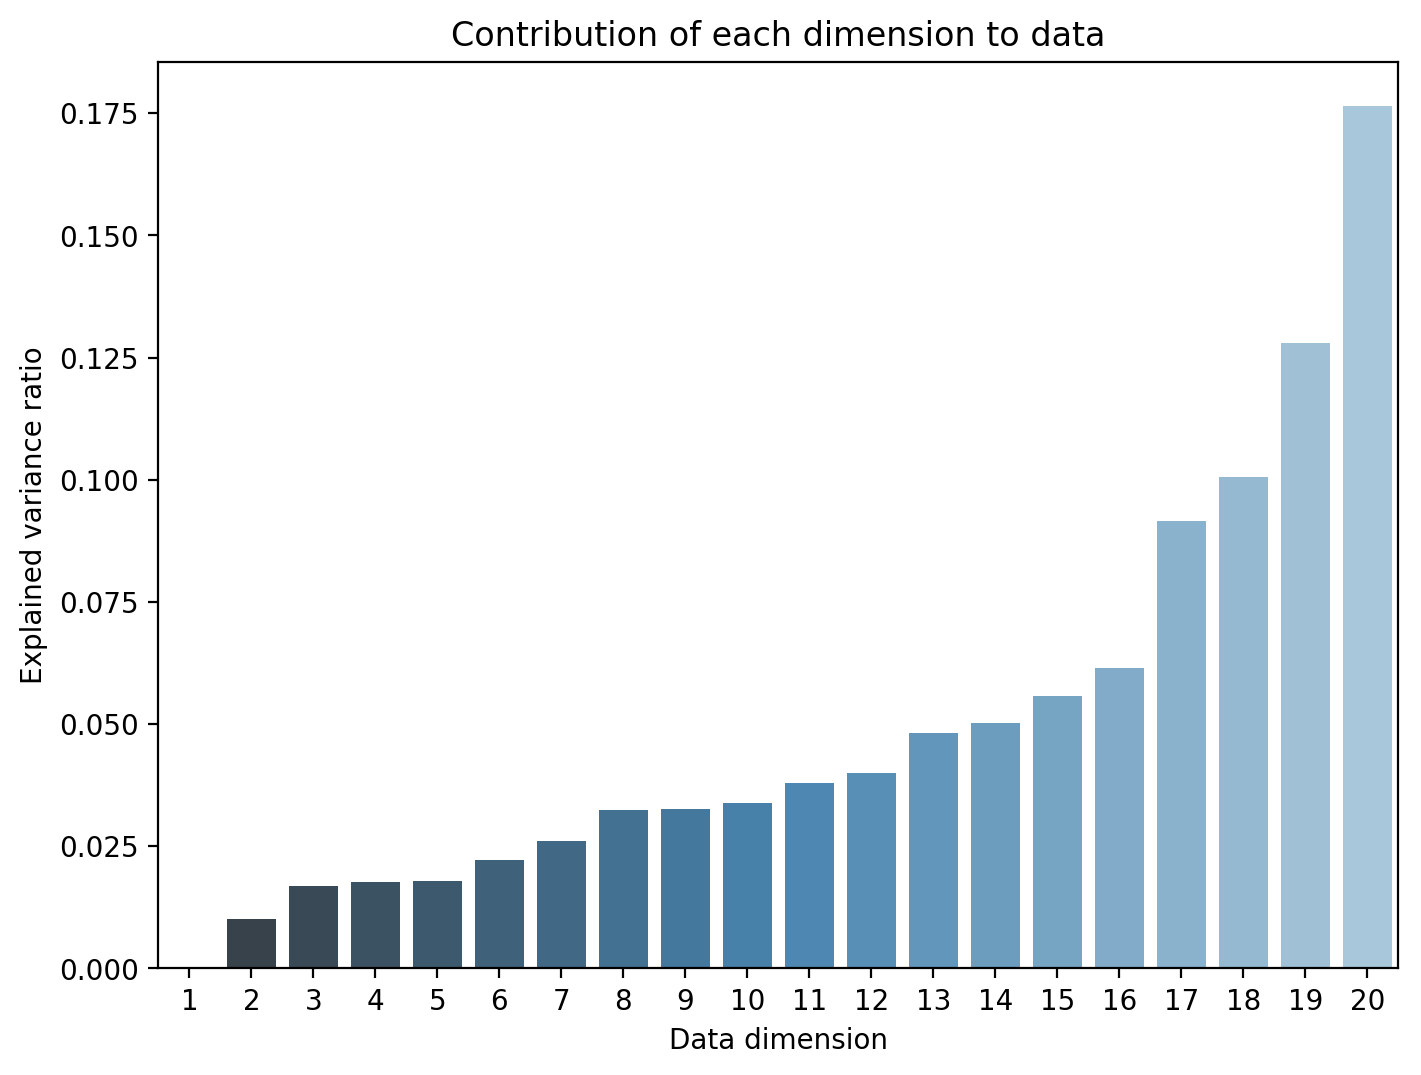

In [45]:
pca = PCA()
pca = pca.fit(data_tmp[data_tmp.columns[1:]])
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
ax.set_ylabel("Explained variance ratio")
ax.set_xlabel("Data dimension")
ax.set_title('Contribution of each dimension to data')
sns.barplot(x = [21-i for i in range(1, 21)], y = pca.explained_variance_ratio_, ax = ax, palette="Blues_d")

## Analyse PCA

In [75]:
pca = PCA(n_components=2)
X, X_2 = train_test_split(data_tmp, test_size = 0.05)
X, y = pd.DataFrame(pca.fit_transform(X_2[X_2.columns[1:]])), X_2['type']
rfc_pca = RandomForestClassifier(n_estimators=100, random_state=42)

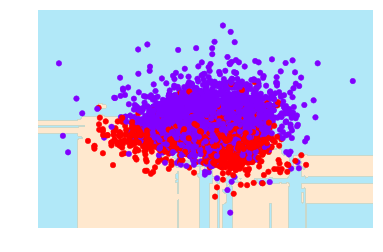

In [77]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
visualize_classifier(rfc_pca, X, y)

#В целом не очень, даже если цвета настроить, видно что из-за самих данных плохо интрепретируется RandomForest

## Classifier (cross validation, ROC AUC on balanced data, confusion matrix)
### 1. cross validation

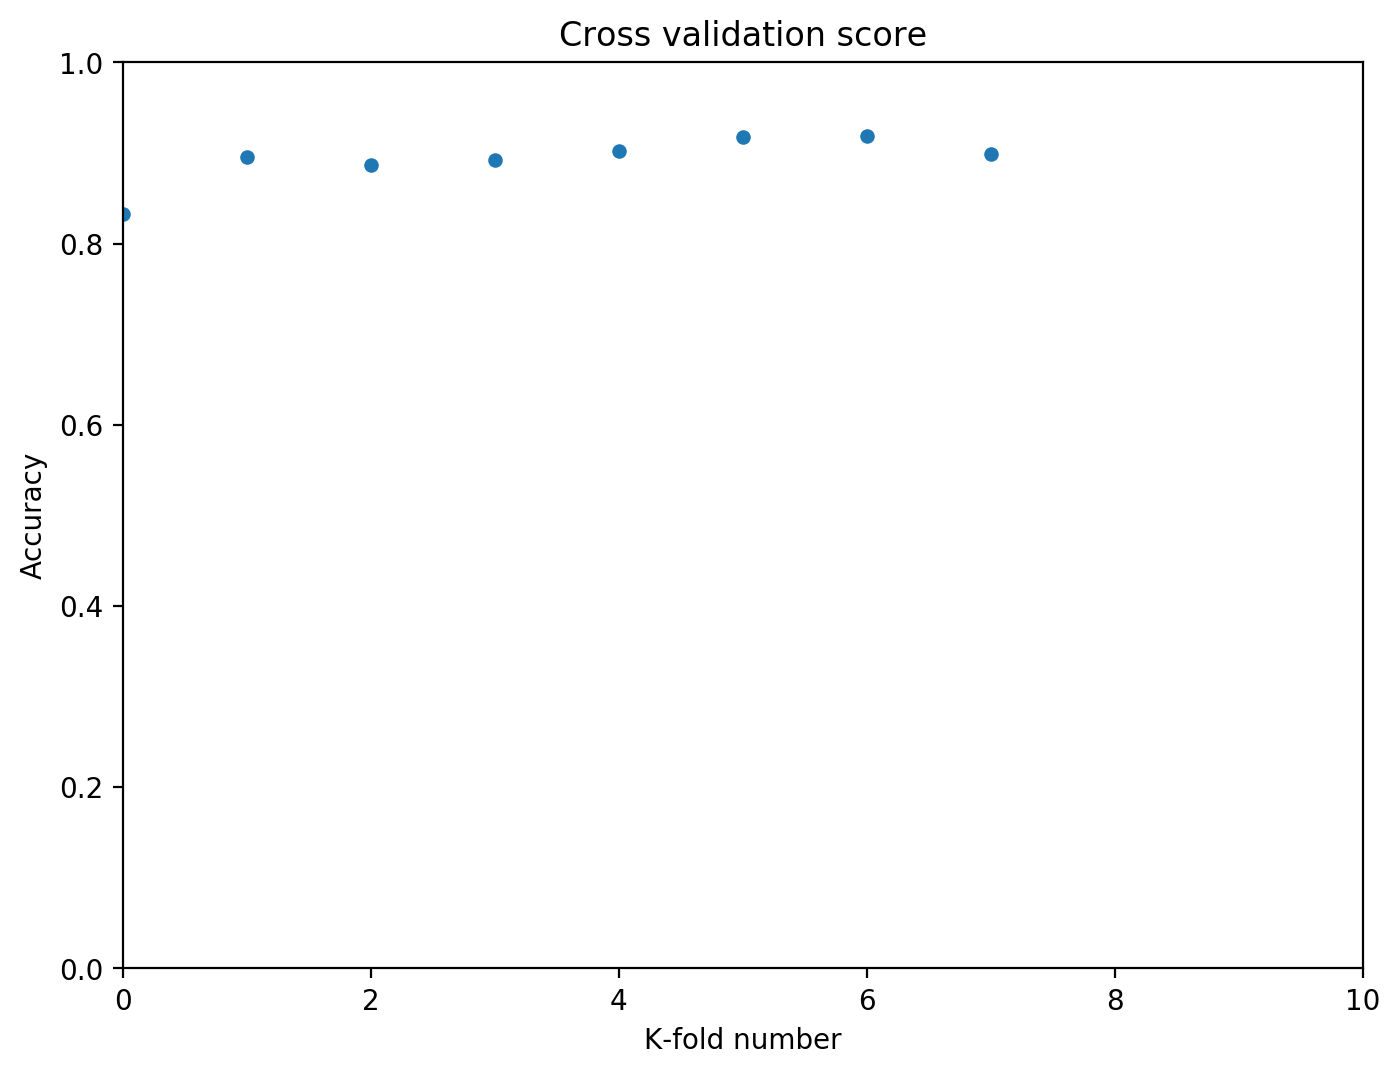

In [124]:
clf = RandomForestClassifier(n_estimators=100, max_features=5)
score_cross_val = cross_val_score(clf, data_tmp[data_tmp.columns[1:]],data_tmp['type'], cv = 8, n_jobs=1)
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
ax.set(xlabel="K-fold number", ylabel="Accuracy", title = 'Cross validation score', xlim = [0, 10], ylim = [0, 1])
sns.scatterplot(x = [i for i in range(len(score_cross_val))], y = score_cross_val, ax = ax)

### 2. ROC AUC on balanced data

In [17]:
x_train_balance, x_test_balance = train_test_split(df_balance)
x_train_balance, y_train_balance = x_train_balance[x_train_balance.columns[1:]], x_train_balance['type']
x_test_balance, y_test_balance = x_test_balance[x_test_balance.columns[1:]], x_test_balance['type']

In [19]:
clf.fit(x_train_balance, y_train_balance)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

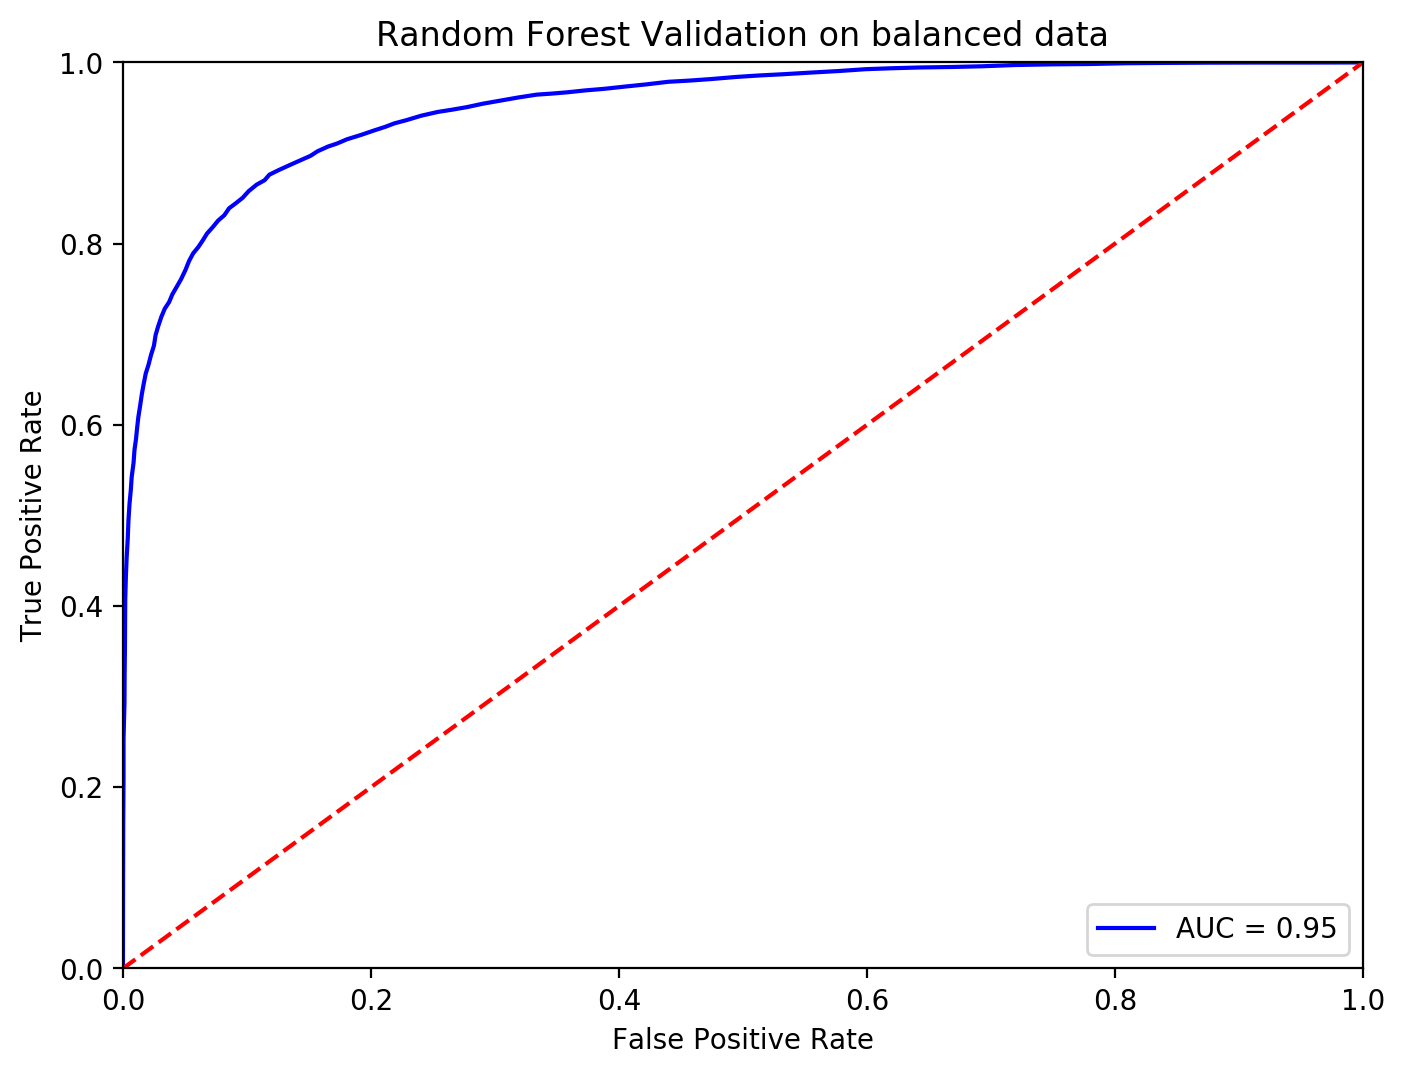

In [28]:
probs = clf.predict_proba(x_test_balance)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test_balance, preds)
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
plt.title('Random Forest Validation on balanced data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 3. Confusion matrix

Confusion matrix, without normalization
[[7181  868]
 [1086 6965]]
Normalized confusion matrix
[[0.89 0.11]
 [0.13 0.87]]


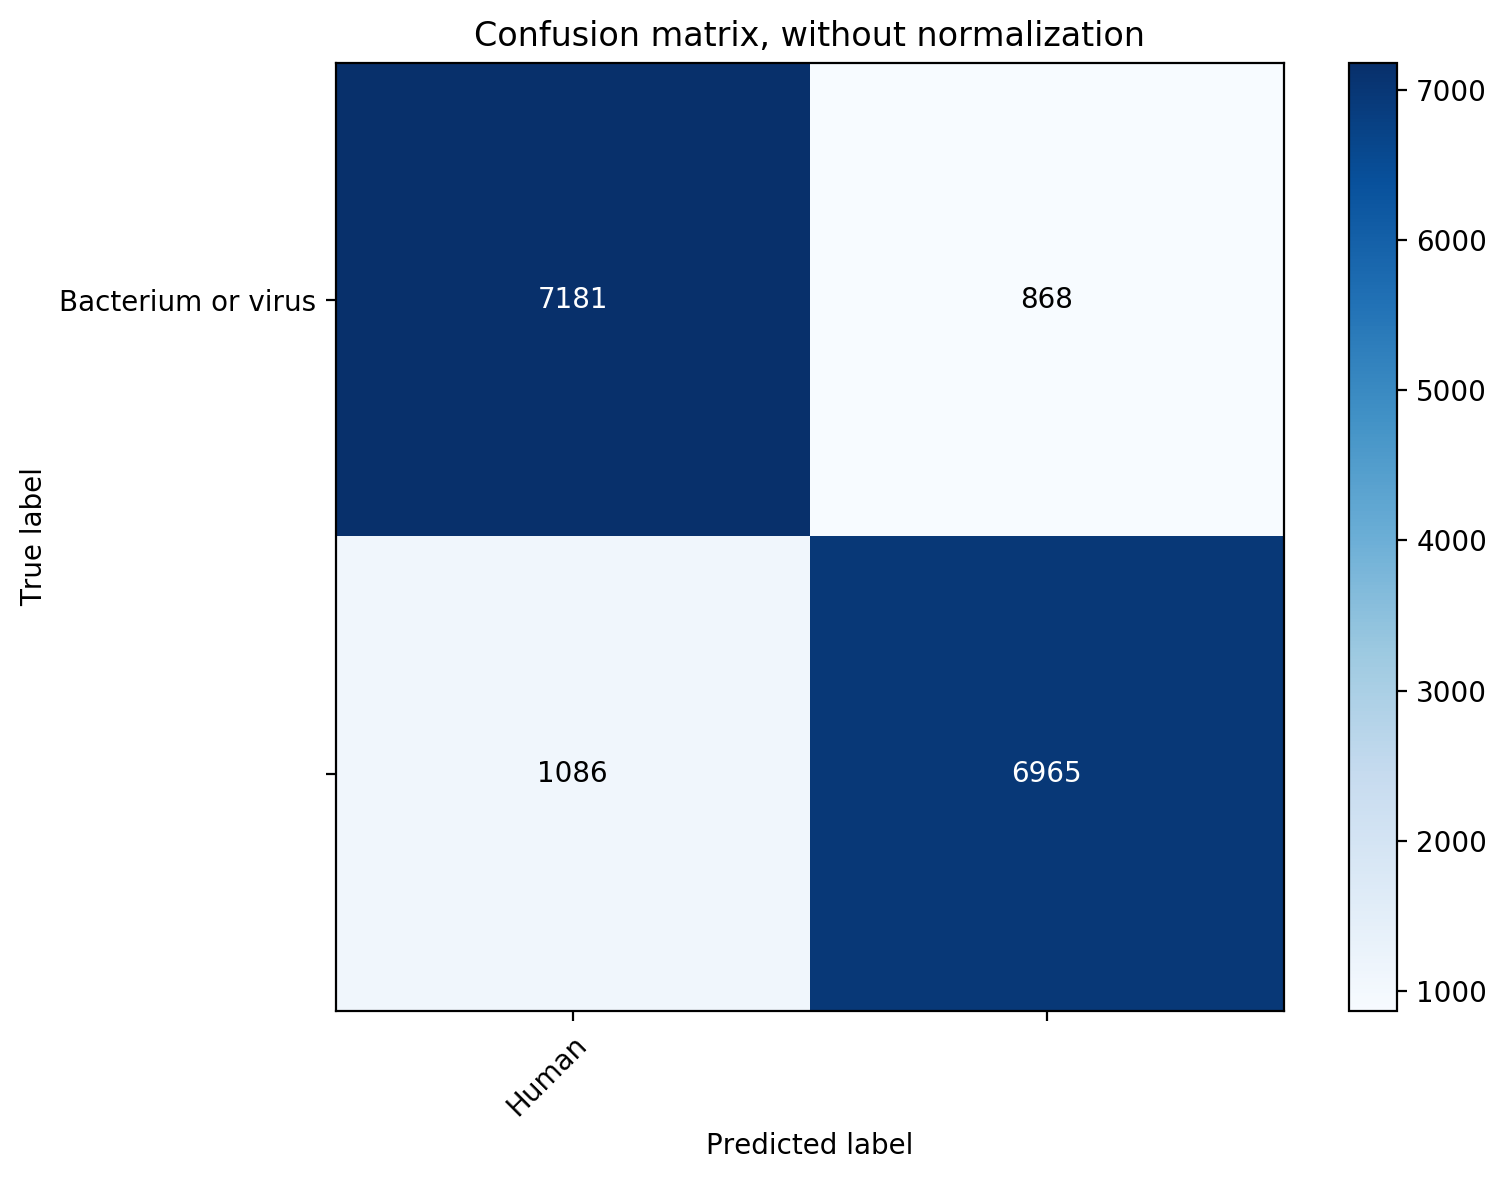

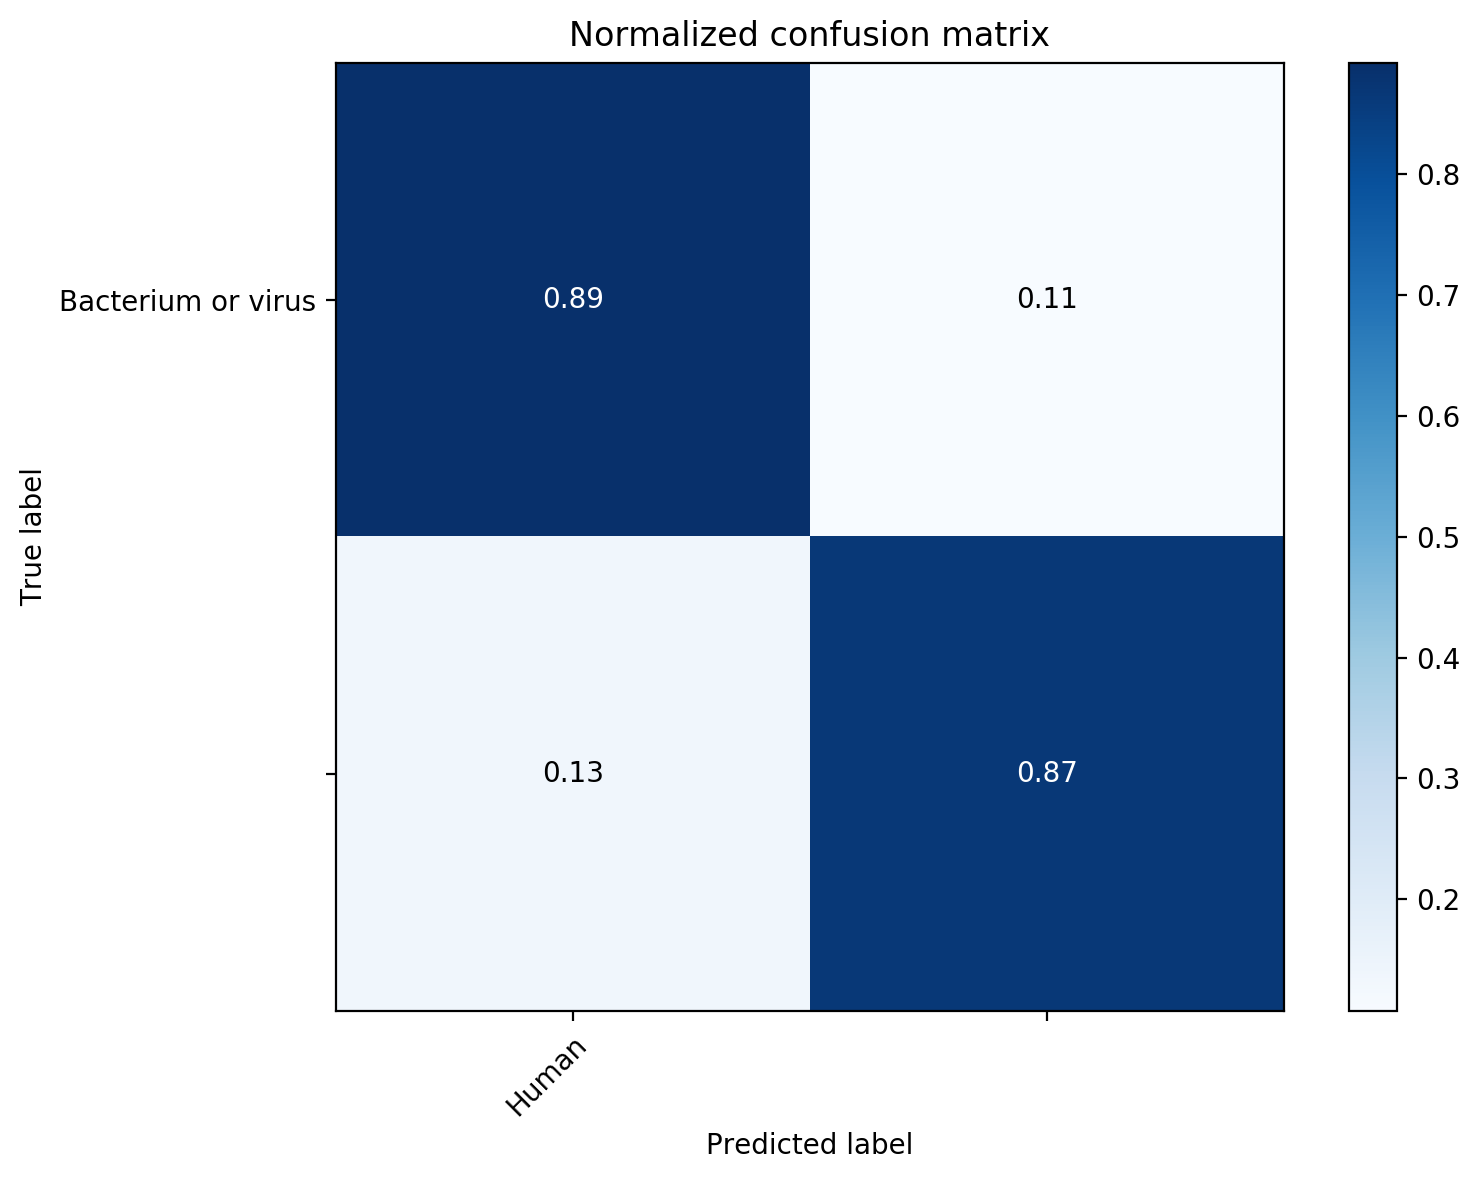

In [45]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=['Human'], yticklabels=['Bacterium or virus'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

y_pred = clf.predict(x_test_balance)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_balance, y_pred, classes=df_balance.columns,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_balance, y_pred, classes=df_balance.columns, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## EDA

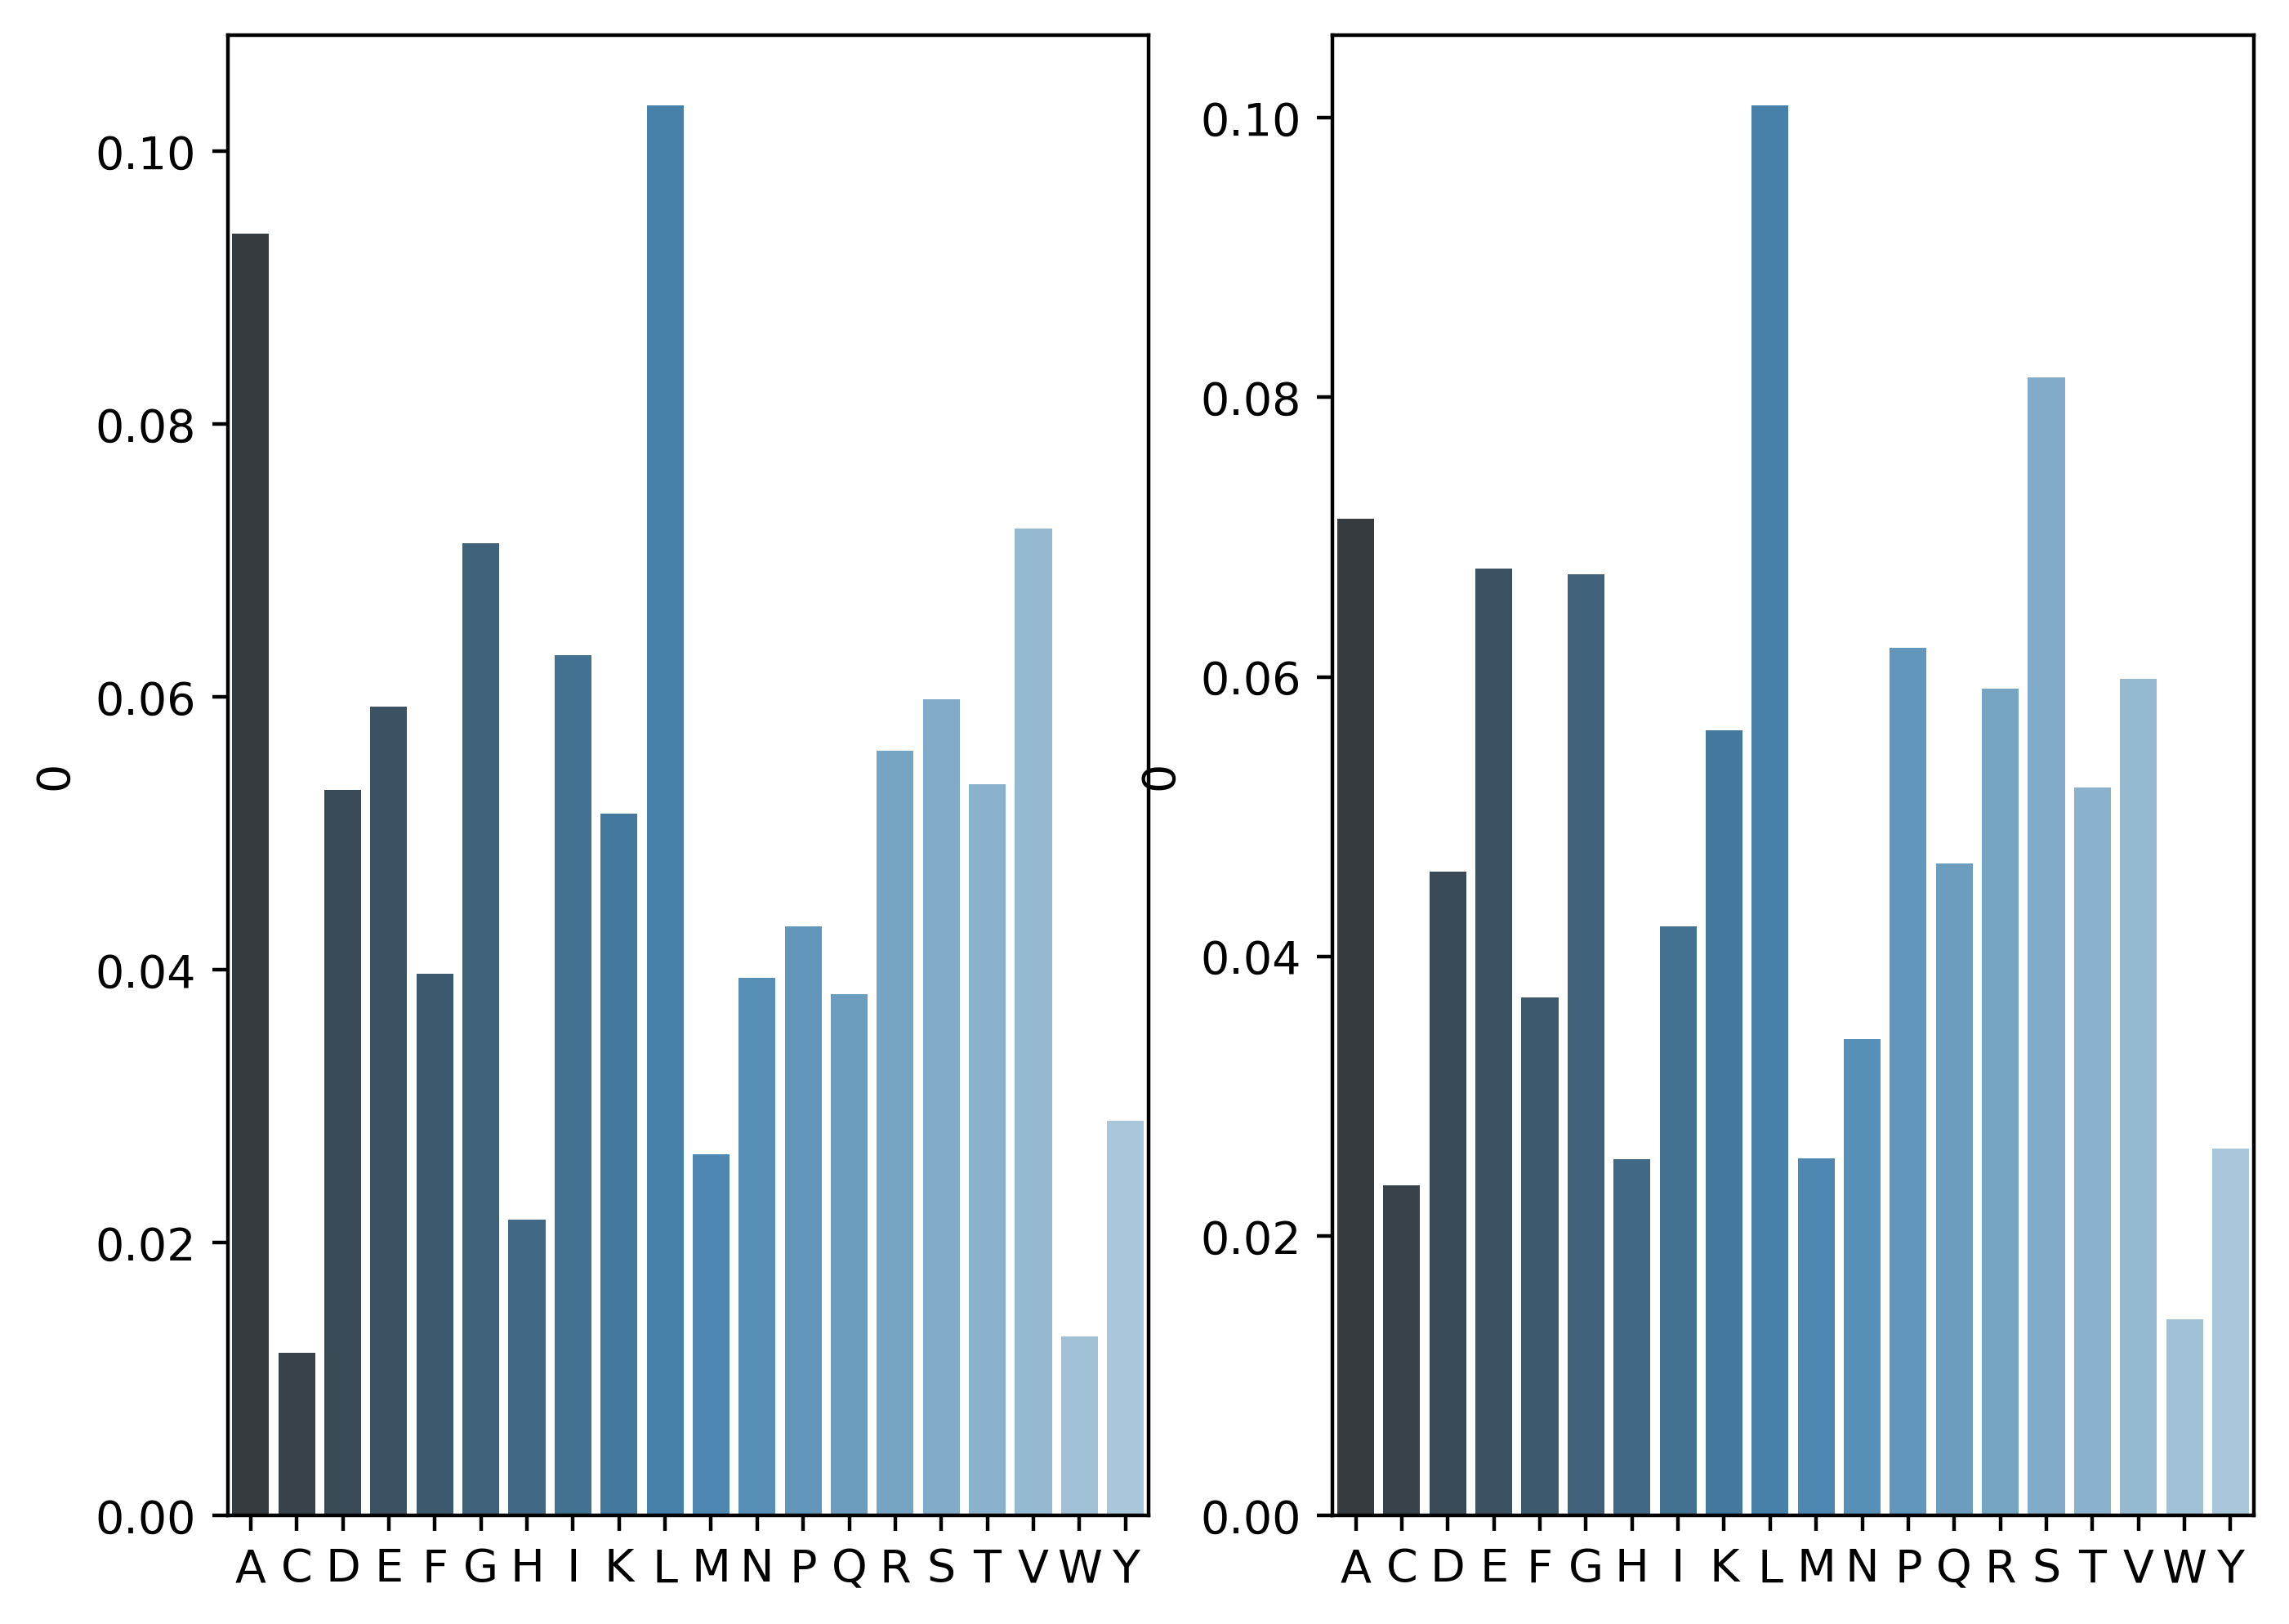

In [112]:
mean_human = []
mean_others = []
for column in data_tmp.columns[1:]:
    mean_human.append(data_tmp[data_tmp['type'] == 1][column].mean())
for column in data_tmp.columns[1:]:
    mean_others.append(data_tmp[data_tmp['type'] == 0][column].mean())
A = {column : mean_human[index] for index, column in enumerate(data_tmp.columns[1:])}
B = {column : mean_others[index] for index, column in enumerate(data_tmp.columns[1:])}
A['type'] = 'Human'
B['type'] = 'Bacterium or virus'
A = pd.DataFrame(A, index=[0])
B = pd.DataFrame(B, index=[0])
C = pd.concat([A,B])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharex=True, dpi = 400)
ax1.set_ylabel
sns.barplot(x = [C.columns[i] for i in range(20)], y = C[C.columns[:-1]].iloc(0)[0], ax = ax1, palette="Blues_d")
sns.barplot(x = [C.columns[i] for i in range(20)], y = C[C.columns[:-1]].iloc(0)[1], ax = ax2, palette="Blues_d")